Loaded data: X shape=(99, 2), y shape=(99,), class balance=[50 49]


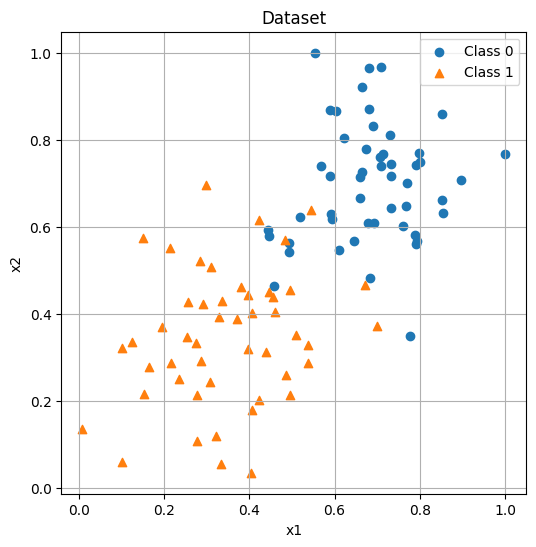

[Part 1] lr=0.01: Training accuracy: 0.929
[Part 1] lr=0.1: Training accuracy: 0.818
[Part 1] lr=1.0: Training accuracy: 0.818


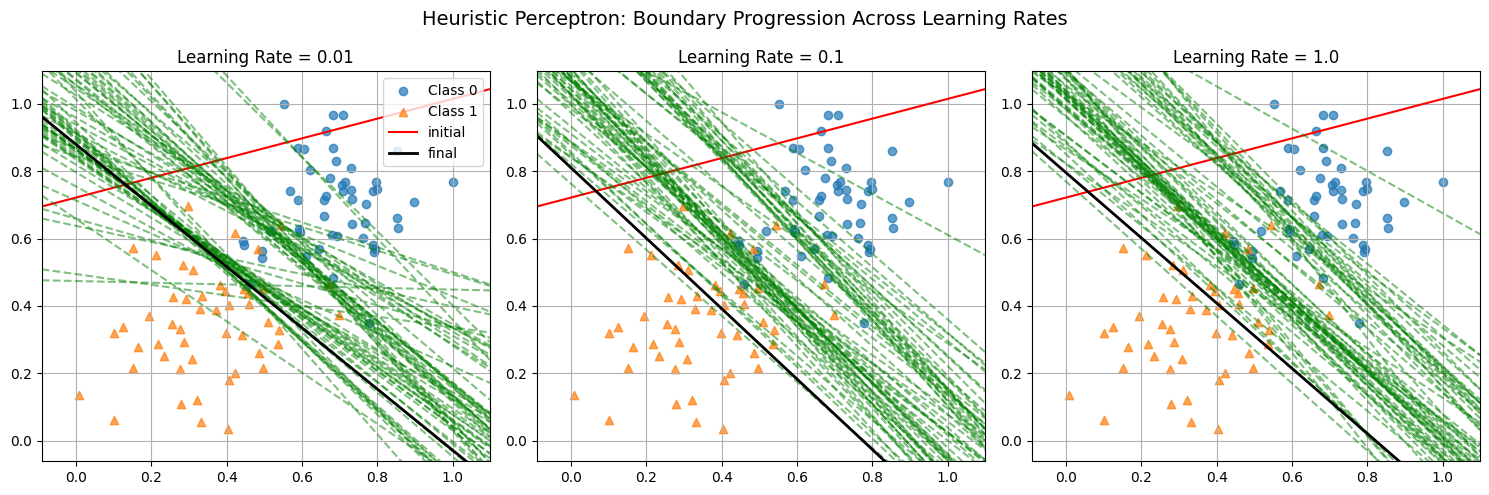

[Part 2] lr=0.1, epochs=100: Training accuracy: 0.737
[Part 2] lr=0.05, epochs=120: Training accuracy: 0.687


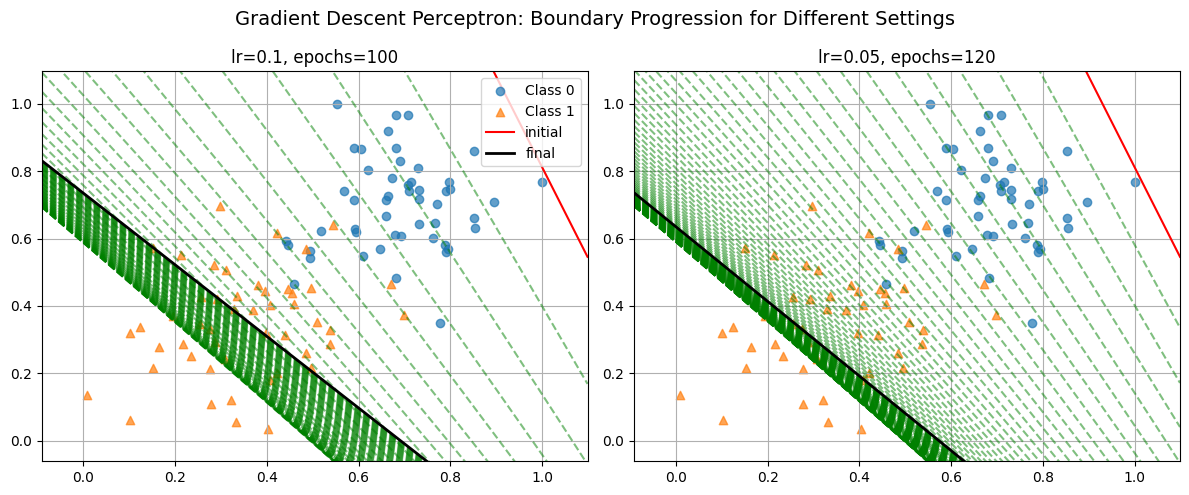

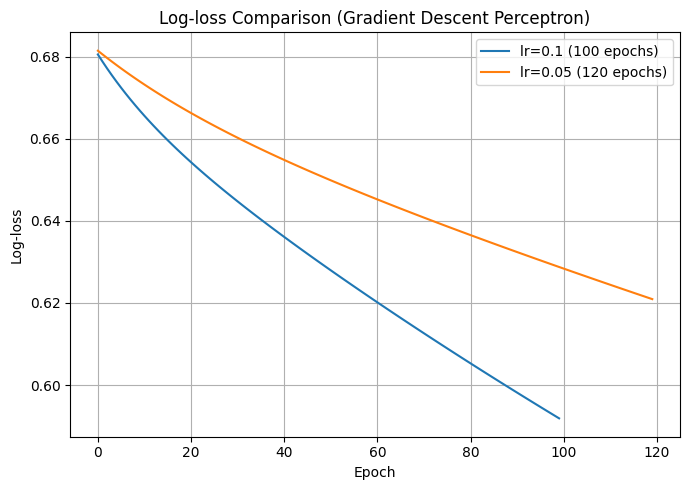

In [5]:
import os
import math
from typing import Dict, List, Tuple

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

plt.rcParams.update({"figure.figsize": (6, 6)})


def load_dataset(possible_paths=("data.csv", "data (1).csv")) -> Tuple[np.ndarray, np.ndarray]:
    path = None
    for p in possible_paths:
        if os.path.exists(p):
            path = p
            break
    if path is None:
        raise FileNotFoundError("Could not find 'data.csv' or 'data (1).csv' in the current directory.")

    df = pd.read_csv(path)
    if df.shape[1] < 3:
        raise ValueError("Expected at least 3 columns: x1, x2, label.")

    cols = list(df.columns)
    candidates_x = [c for c in cols if c.lower() in ("x1", "x_1", "x", "feature1")]
    candidates_y = [c for c in cols if c.lower() in ("x2", "x_2", "y", "feature2")]
    candidates_label = [c for c in cols if c.lower() in ("label", "class", "target", "y_true")]

    if len(candidates_x) and len(candidates_y) and len(candidates_label):
        feature_cols = [candidates_x[0], candidates_y[0]]
        label_col = candidates_label[0]
    else:
        feature_cols = cols[:2]
        label_col = cols[-1]

    X = df[feature_cols].to_numpy(dtype=float)
    y_raw = df[label_col].to_numpy()
    y = normalize_labels(y_raw)
    return X, y


def normalize_labels(y_raw) -> np.ndarray:
    try:
        vals = pd.Series(y_raw).astype(float).values
        unique_vals = set(np.unique(vals))
        if unique_vals == {-1.0, 1.0}:
            return ((vals + 1.0) / 2.0).astype(int)
        if unique_vals <= {0.0, 1.0}:
            return vals.astype(int)
    except Exception:
        pass

    s = pd.Series(y_raw).astype(str).str.lower()
    pos_tokens = {"red", "r", "1", "true", "pos", "positive"}
    neg_tokens = {"blue", "b", "0", "false", "neg", "negative"}
    if set(s.unique()) <= pos_tokens | neg_tokens:
        return (s.isin(pos_tokens)).astype(int).values

    uniq_sorted = sorted(list(set(map(str, y_raw))))
    mapping = {u: int(i == len(uniq_sorted) - 1) for i, u in enumerate(uniq_sorted)}
    return np.array([mapping[str(v)] for v in y_raw], dtype=int)


def plot_data(X: np.ndarray, y: np.ndarray, title: str = "Dataset") -> None:
    class0 = X[y == 0]
    class1 = X[y == 1]
    plt.figure()
    plt.scatter(class0[:, 0], class0[:, 1], marker="o", label="Class 0")
    plt.scatter(class1[:, 0], class1[:, 1], marker="^", label="Class 1")
    plt.xlabel("x1")
    plt.ylabel("x2")
    plt.legend()
    plt.title(title)
    plt.grid(True)
    plt.show()


def line_from_wb(w: np.ndarray, b: float, xlim: Tuple[float, float]) -> Tuple[np.ndarray, np.ndarray]:
    w1, w2 = w
    xs = np.array(xlim)
    if abs(w2) < 1e-12:
        x_const = -b / (w1 + 1e-12)
        xs = np.array([x_const, x_const])
        ys = np.array([xlim[0], xlim[1]])
    else:
        ys = -(w1 * xs + b) / w2
    return xs, ys


def get_plot_limits(X: np.ndarray, pad: float = 0.1):
    xmin, ymin = X.min(axis=0)
    xmax, ymax = X.max(axis=0)
    xr = xmax - xmin
    yr = ymax - ymin
    return (xmin - pad * xr, xmax + pad * xr), (ymin - pad * yr, ymax + pad * yr)


def plot_boundaries(progress_wb: List[Tuple[np.ndarray, float]], X: np.ndarray, y: np.ndarray, title: str) -> None:
    xlim, ylim = get_plot_limits(X)
    class0 = X[y == 0]
    class1 = X[y == 1]

    plt.figure()
    plt.scatter(class0[:, 0], class0[:, 1], marker="o", label="Class 0")
    plt.scatter(class1[:, 0], class1[:, 1], marker="^", label="Class 1")

    if progress_wb:
        xs, ys = line_from_wb(progress_wb[0][0], progress_wb[0][1], xlim)
        plt.plot(xs, ys, "-", color="red", linewidth=2, label="initial")
        for w, b in progress_wb[1:-1]:
            xs, ys = line_from_wb(w, b, xlim)
            plt.plot(xs, ys, "--", color="green", alpha=0.6)
        xs, ys = line_from_wb(progress_wb[-1][0], progress_wb[-1][1], xlim)
        plt.plot(xs, ys, "-", color="black", linewidth=2, label="final")

    plt.xlim(*xlim)
    plt.ylim(*ylim)
    plt.xlabel("x1")
    plt.ylabel("x2")
    plt.title(title)
    plt.grid(True)
    plt.legend()
    plt.show()


class PerceptronHeuristic:
    def __init__(self, lr=0.1, epochs=50, random_state=42, record_every_epoch=True):
        self.lr = lr
        self.epochs = epochs
        self.random_state = random_state
        self.record_every_epoch = record_every_epoch
        self.w = None
        self.b = None
        self.progress: List[Tuple[np.ndarray, float]] = []

    def predict_label(self, X: np.ndarray) -> np.ndarray:
        z = X @ self.w + self.b
        return (z >= 0).astype(int)

    def fit(self, X: np.ndarray, y: np.ndarray) -> "PerceptronHeuristic":
        rng = np.random.default_rng(self.random_state)
        n, d = X.shape
        self.w = rng.normal(scale=0.1, size=d)
        self.b = rng.normal(scale=0.1)
        self.progress = [(self.w.copy(), float(self.b))]

        for _ in range(self.epochs):
            idx = rng.permutation(n)
            for i in idx:
                xi = X[i]
                yi = y[i]
                yhat = int(self.w @ xi + self.b >= 0)
                if yhat != yi:
                    if yhat == 0:
                        self.b += self.lr
                        self.w += self.lr * xi
                    else:
                        self.b -= self.lr
                        self.w -= self.lr * xi
            if self.record_every_epoch:
                self.progress.append((self.w.copy(), float(self.b)))

        return self


def sigmoid(z: np.ndarray) -> np.ndarray:
    z = np.clip(z, -60, 60)
    return 1.0 / (1.0 + np.exp(-z))


def log_loss(y_true: np.ndarray, y_prob: np.ndarray, eps: float = 1e-12) -> float:
    y_prob = np.clip(y_prob, eps, 1 - eps)
    return -np.mean(y_true * np.log(y_prob) + (1 - y_true) * np.log(1 - y_prob))


class PerceptronGradient:
    def __init__(self, lr=0.1, epochs=100, random_state=123, record_every_epoch=True):
        self.lr = lr
        self.epochs = epochs
        self.random_state = random_state
        self.record_every_epoch = record_every_epoch
        self.w = None
        self.b = None
        self.progress: List[Tuple[np.ndarray, float]] = []
        self.losses: List[float] = []

    def predict_prob(self, X: np.ndarray) -> np.ndarray:
        return sigmoid(X @ self.w + self.b)

    def predict_label(self, X: np.ndarray) -> np.ndarray:
        return (self.predict_prob(X) >= 0.5).astype(int)

    def fit(self, X: np.ndarray, y: np.ndarray) -> "PerceptronGradient":
        rng = np.random.default_rng(self.random_state)
        n, d = X.shape
        self.w = rng.normal(scale=0.1, size=d)
        self.b = rng.normal(scale=0.1)
        self.progress = [(self.w.copy(), float(self.b))]
        self.losses = []

        for _ in range(self.epochs):
            z = X @ self.w + self.b
            yhat = sigmoid(z)
            grad_w = -(y - yhat) @ X / n
            grad_b = -np.mean(y - yhat)
            self.w -= self.lr * grad_w
            self.b -= self.lr * grad_b
            ll = log_loss(y, sigmoid(X @ self.w + self.b))
            self.losses.append(ll)
            if self.record_every_epoch:
                self.progress.append((self.w.copy(), float(self.b)))

        return self


def run_part1(X: np.ndarray, y: np.ndarray, lr: float = 0.1, epochs: int = 50):
    model = PerceptronHeuristic(lr=lr, epochs=epochs, record_every_epoch=True)
    model.fit(X, y)
    plot_boundaries(model.progress, X, y, title=f"Part 1 (Heuristic) — lr={lr}, epochs={epochs}")
    acc = (model.predict_label(X) == y).mean()
    print(f"[Part 1] Training accuracy: {acc:.3f}")
    return model, acc


def run_part2(X: np.ndarray, y: np.ndarray, lr: float = 0.1, epochs: int = 100):
    model = PerceptronGradient(lr=lr, epochs=epochs, record_every_epoch=True)
    model.fit(X, y)
    plot_boundaries(model.progress, X, y, title=f"Part 2 (Gradient Descent + Sigmoid) — lr={lr}, epochs={epochs}")

    xs = np.arange(1, epochs + 1)
    sampled_x = xs[xs % 10 == 0]
    sampled_loss = [model.losses[i - 1] for i in sampled_x]
    plt.figure(figsize=(6, 4))
    plt.plot(sampled_x, sampled_loss, marker="o")
    plt.xlabel("Number of epochs (every 10)")
    plt.ylabel("Log-loss (Error)")
    plt.title(f"Error Plot (every 10 epochs) — lr={lr}, epochs={epochs}")
    plt.grid(True)
    plt.show()

    acc = (model.predict_label(X) == y).mean()
    print(f"[Part 2] Training accuracy: {acc:.3f}")
    return model, acc


X, y = load_dataset()
print(f"Loaded data: X shape={X.shape}, y shape={y.shape}, class balance={np.bincount(y)}")
plot_data(X, y, title="Dataset")

# Part 1: Side-by-side comparison of different learning rates
lrs = [0.01, 0.1, 1.0]
fig, axes = plt.subplots(1, 3, figsize=(15, 5))

for ax, lr in zip(axes, lrs):
    model = PerceptronHeuristic(lr=lr, epochs=65)
    model.fit(X, y)
    
    class0 = X[y == 0]
    class1 = X[y == 1]
    ax.scatter(class0[:, 0], class0[:, 1], marker='o', label='Class 0', alpha=0.7)
    ax.scatter(class1[:, 0], class1[:, 1], marker='^', label='Class 1', alpha=0.7)
    
    # Plot boundary progression
    xlim, ylim = get_plot_limits(X)
    xs, ys = line_from_wb(model.progress[0][0], model.progress[0][1], xlim)
    ax.plot(xs, ys, '-', color='red', label='initial')
    
    for w, b in model.progress[1:-1]:
        xs, ys = line_from_wb(w, b, xlim)
        ax.plot(xs, ys, '--', color='green', alpha=0.5)
    
    xs, ys = line_from_wb(model.progress[-1][0], model.progress[-1][1], xlim)
    ax.plot(xs, ys, '-', color='black', linewidth=2, label='final')
    
    ax.set_xlim(*xlim)
    ax.set_ylim(*ylim)
    ax.set_title(f"Learning Rate = {lr}")
    ax.grid(True)
    
    # Print accuracy
    acc = (model.predict_label(X) == y).mean()
    print(f"[Part 1] lr={lr}: Training accuracy: {acc:.3f}")

axes[0].legend()
fig.suptitle("Heuristic Perceptron: Boundary Progression Across Learning Rates", fontsize=14)
plt.tight_layout()
plt.savefig("part1_boundaries.png", dpi=300)
plt.show()

# Part 2: Gradient Descent with Sigmoid - Boundary Comparison
configs = [(0.1, 100), (0.05, 120)]
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

for ax, (lr, epochs) in zip(axes, configs):
    model = PerceptronGradient(lr=lr, epochs=epochs)
    model.fit(X, y)
    
    class0 = X[y == 0]
    class1 = X[y == 1]
    ax.scatter(class0[:, 0], class0[:, 1], marker='o', label='Class 0', alpha=0.7)
    ax.scatter(class1[:, 0], class1[:, 1], marker='^', label='Class 1', alpha=0.7)
    
    # Plot boundary progression
    xlim, ylim = get_plot_limits(X)
    xs, ys = line_from_wb(model.progress[0][0], model.progress[0][1], xlim)
    ax.plot(xs, ys, '-', color='red', label='initial')
    
    for w, b in model.progress[1:-1]:
        xs, ys = line_from_wb(w, b, xlim)
        ax.plot(xs, ys, '--', color='green', alpha=0.5)
    
    xs, ys = line_from_wb(model.progress[-1][0], model.progress[-1][1], xlim)
    ax.plot(xs, ys, '-', color='black', linewidth=2, label='final')
    
    ax.set_xlim(*xlim)
    ax.set_ylim(*ylim)
    ax.set_title(f"lr={lr}, epochs={epochs}")
    ax.grid(True)
    
    # Print accuracy
    acc = (model.predict_label(X) == y).mean()
    print(f"[Part 2] lr={lr}, epochs={epochs}: Training accuracy: {acc:.3f}")

axes[0].legend()
fig.suptitle("Gradient Descent Perceptron: Boundary Progression for Different Settings", fontsize=14)
plt.tight_layout()
plt.savefig("part2_boundaries.png", dpi=300)
plt.show()

# Part 2: Error Plot Comparison
plt.figure(figsize=(7, 5))
model1 = PerceptronGradient(lr=0.1, epochs=100)
model1.fit(X, y)
plt.plot(model1.losses, label="lr=0.1 (100 epochs)")

model2 = PerceptronGradient(lr=0.05, epochs=120)
model2.fit(X, y)
plt.plot(model2.losses, label="lr=0.05 (120 epochs)")

plt.xlabel("Epoch")
plt.ylabel("Log-loss")
plt.title("Log-loss Comparison (Gradient Descent Perceptron)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.savefig("part2_error.png", dpi=300)
plt.show()

